In [73]:
import argparse
import os, sys
import time
import datetime
import numpy as np

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

# You cannot change this line.
from tools.dataloader import CIFAR10

In [2]:
""" 
Assignment 2(a)
Build the LeNet-5 model by following table 1 or figure 1.

You can also insert batch normalization and leave the LeNet-5 
with batch normalization here for assignment 3(c).
"""
# Create the neural network module: LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv1_bn = nn.BatchNorm2d(6,affine = True)
        self.conv2 = nn.Conv2d(6,16,5)
        self.conv2_bn = nn.BatchNorm2d(16,affine = True)
        self.fc1 = nn.Linear(400,120)
        self.fc1_bn = nn.BatchNorm1d(120,affine = True)
        self.fc2 = nn.Linear(120,84)
        self.fc2_bn = nn.BatchNorm1d(84,affine = True)
        self.fc3 = nn.Linear(84,10)
        self.fc3_bn = nn.BatchNorm1d(10,affine = True)
                      
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))),(2,2))
        x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))),(2,2))
        x = x.view(-1,400)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3_bn(self.fc3(x))
        
        # x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        # x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        # x = x.view(-1,400)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [3]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 50
INITIAL_LR = 0.1
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 10
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"

**Your answer:**

In [4]:
"""
Assignment 2(b)
Write functions to load dataset and preprocess the incoming data. 
We recommend that the preprocess scheme \textbf{must} include 
normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. 
The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

mean(RGB-format): (0.4914, 0.4822, 0.4465)
std(RGB-format): (0.2023, 0.1994, 0.2010)


NOTE: Considering this process has strong corrlelation with assignment 3(b), 
please leave the data preprocessing method which can achieve the highest 
validation accuracy here. You can include your original data augmentation
method as comments and denotes the accuracy difference between thest two 
methods.
"""
# Specify preprocessing function.
# Reference mean/std value for 
"""transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])"""

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))])

**Your answer:**

In [88]:
# Call the dataset Loader
trainset = CIFAR10(root=DATAROOT, train=True, download=False, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                          num_workers=1)
valset = CIFAR10(root=DATAROOT, train=False, download=False, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, 
                                        num_workers=1)

In [89]:
len(valset)

10000

In [6]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [7]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = False
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

[Errno 2] No such file or directory: './saved_model/model.h5'
Checkpoint not found.
Training from scratch ...
Starting from learning rate 0.100000:


In [8]:
"""
Assignment 2(c)
In the targeted classification task, we use cross entropy loss with L2 
regularization as the learning object.
You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.
We recommend you to use the SGD-momentum with an initial learning rate 0.01 
and momentum 0.9 as a start.
"""
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(),lr=INITIAL_LR,momentum=MOMENTUM,weight_decay=REG)

In [9]:
# Implement Augmentation and batch normalization
global_step = 0
best_val_acc = 0
train_acc_list = []
val_acc_list = []

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs to device
        inputs = inputs.cuda()
        targets = targets.cuda()
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs,targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = outputs.max(1)
        # Calculate accuracy
        total_examples += len(targets)
        correct_examples += np.sum((predicted.cpu() - targets.cpu()).numpy() == 0)

        train_loss += loss

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    train_acc_list.append(avg_acc)
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs,targets)
            # Calculate predicted labels
            _, predicted = outputs.max(1)
            # Calculate accuracy
            total_examples += len(targets)
            correct_examples +=  np.sum((predicted.cpu() - targets.cpu()).numpy() == 0)
            val_loss += loss

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    val_acc_list.append(avg_acc)
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
    DECAY_EPOCHS = 2
    DECAY = 0.95
    if i % DECAY_EPOCHS == 0 and i != 0:
        if i == 0:
            current_learning_rate = INITIAL_LR
        else:
            current_learning_rate *= DECAY
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
            print("Current learning rate has decayed to %f"%current_learning_rate)
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

2019-10-01 15:03:14.673141
Epoch 0:
352
Training loss: 1.5367, Training accuracy: 0.4588
2019-10-01 15:03:34.547501
Validation...
Validation loss: 1.3313, Validation accuracy: 0.5224
Saving ...
2019-10-01 15:03:37.312527
Epoch 1:
352
Training loss: 1.2257, Training accuracy: 0.5634
2019-10-01 15:03:52.555393
Validation...
Validation loss: 1.2676, Validation accuracy: 0.5454
Saving ...
2019-10-01 15:03:55.466292
Epoch 2:
352
Training loss: 1.1255, Training accuracy: 0.6024
2019-10-01 15:04:09.906427
Validation...
Validation loss: 1.1183, Validation accuracy: 0.5946
Current learning rate has decayed to 0.095000
Saving ...
2019-10-01 15:04:12.841425
Epoch 3:
352
Training loss: 1.0365, Training accuracy: 0.6299
2019-10-01 15:04:27.569856
Validation...
Validation loss: 1.0874, Validation accuracy: 0.6196
Saving ...
2019-10-01 15:04:30.238966
Epoch 4:
352
Training loss: 0.9859, Training accuracy: 0.6522
2019-10-01 15:04:45.121465
Validation...
Validation loss: 1.1044, Validation accuracy: 0.

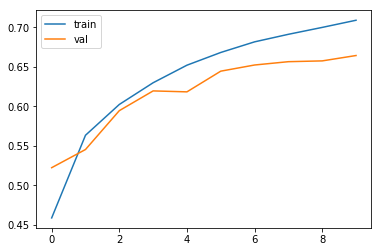

In [98]:
import matplotlib.pyplot as plt

plt.plot(range(EPOCHS),train_acc_list,label='train')
plt.plot(range(EPOCHS),val_acc_list,label='val')
plt.legend()
plt.show()